# Задача 13.4

In [1]:
from IPython.display import Image

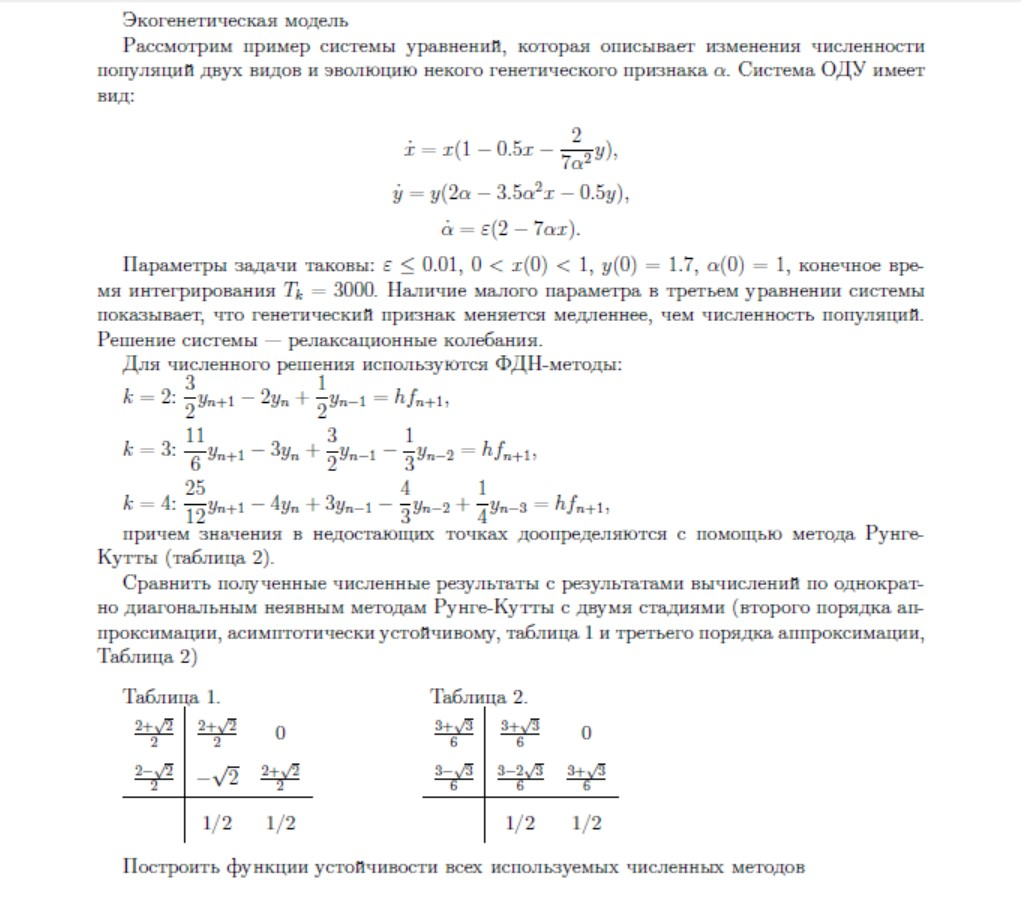

In [2]:
Image(filename='13.4.jpg') 

### Правая часть системы
Заметим, что она не зависит явным образом от $t$, т.е. $f = f(u)$.

In [34]:
def f(u, epsilon=0.01):
    x, y, alpha = u
    return np.array([
        x*(1 - x/2 -(7/2/alpha**2)*y),
        y*(2*alpha - (7/2*alpha**2)*x - y/2),
        epsilon*(2 - 7*alpha*x)
    ])

## Реализация методов

In [4]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

### Однократно диагонально неявные методы Рунге-Кутты

В общем случае решается система уравнений вида
$$\dot{u} = f\left(t, u(t)\right), \quad f:\mathbb{R}\times\mathbb{R}^n\rightarrow\mathbb{R}^n$$

s-стадийным неявным методом Рунге-Кутты (РК) с определяющими коэффициентами $a_{ij}$, $b_i$, $c_i$ называется метод вида

$$u^{n+1}=u^{n}+\tau \sum_{i=1}^{s} b_{i} k_{i}$$
$$k_{i}=f\left(t_{n}+c_{i} \tau, u^{n}+\tau \sum_{j=1}^s a_{i j} k_{j}\right)$$

В данной задаче используются однократно диагонально неявные методы РК, т.е. такие, что для них выполнено $a_{i j}=0,\space j>i$ и $\forall i \mapsto a_{i i}=a$.

В этих условиях для вычисления $k_i$ требуется решить нелинейное уравнение следующего вида:

$$F(k_i) = f\left(t_{n}+c_{i} \tau, u^{n}+\tau \sum_{j=1}^{i-1} a_{i j} k_{j} + \tau a k_i\right) - k_{i} = 0$$

Так как система ДУ из условия задачи является автономной, нелинейное уравнение преобразуется к виду:

$$F(k_i) = f\left(u^{n}+\tau \sum_{j=1}^{i-1} a_{i j} k_{j} + \tau a k_i\right) - k_{i} = 0$$

Будем решать его с помощью функции `fsolve` пакета `scipy.optimize`.

In [10]:
class SDIRK_AutonomousSystem:
    """
    Однократно диагонально неявные методы Рунге-Кутты для автономных систем дифференциальных уравнений.

        Параметры:
        a_matrix - матрица размера sxs с a_ij = 0, i>j и a_ii=a для всех i
        b_vector, c_vector - векторы размера sx1
    """
    def __init__(self, a_matrix, b_vector, c_vector):
        self.__A = a_matrix
        self.__a = a_matrix[0][0]
        self.__b = b_vector
        self.__c = c_vector
        self.__s = len(b_vector)
        
        
    def __nonlinear_equation(self, k_i, func, k, i, tau, u_n, params):
        return func(
            u_n 
            + tau*self.__A[i - 1][:i - 1] @ k[1:i]
            + tau*self.__a*k_i,
            **params
        ) - k_i
    
    
    def __call__(self, func, t_0, t_max, tau, u_0, **params):
        """
        Обсчет системы ДУ с правой частью func(u) на отрезке [t_0, t_max] с шагом tau (НУ u(t_0) = u_0).
        
        Параметры:
        func - функция правой части дифференциального уравнения f(t, u)
        t_0 - левая граница отрезка, на котором решается задача Коши
        t_max - правая граница отрезка, на котором решается задача Коши
        tau - величина шага на итерации
        u_0 - значение u(t_0)

        Возвращает значения u на сетке.
        """
        dim = len(u_0)  # размерность системы
        N = int((t_max - t_0) / tau) # число шагов
        u = np.zeros((N+1, dim))  # вектор u(t) в узлах сетки
        u[0] = u_0  # начальное приближение
        for n in range(N):
            k = np.zeros((self.__s + 1, dim))
            for i in range(1, self.__s + 1):
                k[i] = fsolve(self.__nonlinear_equation, k[i-1], args=(func, k, i, tau, u[n], params))
            u[n + 1] = u[n] + tau * self.__b @ k[1:]
        return [t_0 + n * tau for n in range(N+1)], u  # сетка и решение

In [11]:
from math import sqrt

In [12]:
table1 = [
    np.array([  # А
        [(2 + sqrt(2))/2, 0],
        [-sqrt(2), (2 + sqrt(2))/2]
    ]),
    np.array([1/2]*2),  # b
    np.array([(2 + sqrt(2))/2, (2 - sqrt(2))/2])  # c
    
]

table2 = [
    np.array([  # А
        [(3 + sqrt(3))/6, 0],
        [(3 - 2*sqrt(3))/6, (3 + sqrt(3))/6]
    ]),
    np.array([1/2]*2),  # b
    np.array([(3 + sqrt(3))/6, (3 - sqrt(3))/6])  # c
]

In [13]:
RK_order2, RK_order3 = SDIRK_AutonomousSystem(*table1), SDIRK_AutonomousSystem(*table2)

In [14]:
t2, x2 = RK_order2(lambda x: 5*x, 0, 1, 0.005, [1])
t3, x3 = RK_order3(lambda x: 5*x, 0, 1, 0.005, [1])

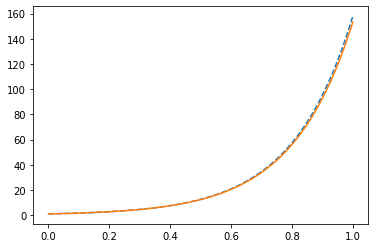

In [16]:
plt.plot(t2, x2, '--', t3, x3)
None

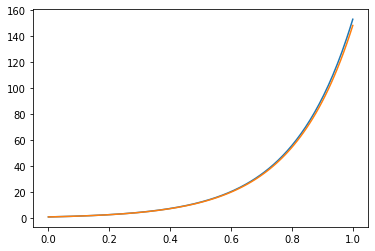

In [17]:
tt = np.linspace(0, 1, 100)
def f(x):
    return np.exp(5*x)
plt.plot(t3, x3, tt, f(tt))
None

### ФДН-методы

В задаче используются следующие методы ($k$ - порядок аппроксимации):
    
$$
\begin{array}{l}
k=2: \frac{3}{2} u_{n+1}-2 u_{n}+\frac{1}{2} u_{n-1}=\tau\space f_{n+1} \\
k=3: \frac{11}{6} u_{n+1}-3 u_{n}+\frac{3}{2} u_{n-1}-\frac{1}{3} u_{n-2}=\tau\space f_{n+1} \\
k=4: \frac{25}{12} u_{n+1}-4 u_{n}+3 u_{n-1}-\frac{4}{3} u_{n-2}+\frac{1}{4} u_{n-3}=\tau\space f_{n+1}
\end{array}
$$

или в более удобном для реализации виде (учитывая, что решаемая система - автономная):

$$
\left(\overrightarrow {K}, u_{n-k+1}^{n+1}\right)=\tau\space f_{n+1} = \tau\space f\left(u^{n+1}\right),
$$

где $\overrightarrow {K}$ - вектор коэффициентов ФДН-метода, а $u_{n-k+1}^{n+1} = \left(u^{n-k+1}, u^n, \dots, u^{n+1}\right)^T$, $k$ - порядок аппроксимации формулы.

Таким образом для нахождения значения $u^{n+1}$ требуется решить следующую нелинейную систему:

$$
F\left(u^{n+1}\right) = \left(\overrightarrow {K}, u_{n-k+1}^{n+1}\right) - \tau\space f\left(u^{n+1}\right) = 0,
$$

Видно, что для корректного решения задачи с помощью ФДН-метода порядка аппроксимации $k$ требуется дополнительно задать начальные значения функции в $k-1$ точках $u^1, \dots, u^{k-1}$. Значения в этих точках будут вычислены с помощью однократно диагонально неявного метода РК 3-го порядка аппроксимации (см. выше).

In [78]:
class BDF_AutonomousSystem:
    """
    ФДН-методы для автономных систем дифференциальных уравнений.

        Параметры:
        K - вектор коэффициентов метода размерности k+1 
        (начиная с точки с наименьшим индексом, k - порядок аппроксимации метода)
    """
    def __init__(self, K):
        self.__K = K
        self.__k = len(K) - 1

        
    def __nonlinear_equation(self, u_next, func, u, i, tau, params):
        print(func(u_next, **params))
        print(i, u)
        print(np.append(u[i-self.__k: i, :], u_next))
        print(self.__K)
        return np.dot(np.append(u[i-self.__k: i], u_next), self.__K) - tau*func(u_next, **params)
        
        
    def __call__(self, func, t_0, t_max, tau, u_0, **params):
        """
        Обсчет системы ДУ с правой частью func(u) на отрезке [t_0, t_max] с шагом tau (НУ u(t_0) = u_0).
        
        Параметры:
        func - функция правой части дифференциального уравнения f(t, u)
        t_0 - левая граница отрезка, на котором решается задача Коши
        t_max - правая граница отрезка, на котором решается задача Коши
        tau - величина шага на итерации
        u_0 - значение u(t_0)

        Возвращает значения u на сетке.
        """
        dim = len(u_0)  # размерность системы
        N = int((t_max - t_0) / tau) # число шагов
        u = np.zeros((N+1, dim))  # вектор u(t) в узлах сетки
        u[0] = u_0  # начальное приближение
        RK_order3 = SDIRK_AutonomousSystem(*[  # метод РК для нахождения значений в первых k-1 точках
                np.array([  # А
                    [(3 + sqrt(3))/6, 0],
                    [(3 - 2*sqrt(3))/6, (3 + sqrt(3))/6]
                ]),
                np.array([1/2]*2),  # b
                np.array([(3 + sqrt(3))/6, (3 - sqrt(3))/6])  # c
            ])
        for i in range(1, self.__k):
            u[i] = RK_order3(func, t_0 + (i-1)*tau, t_0 + i*tau, tau, u[i-1])[1][-1]
        for i in range(self.__k, N+1):
            u[i] = fsolve(self.__nonlinear_equation, u[i-1], args=(func, u, i, tau, params))
        return [t_0 + n * tau for n in range(N+1)], u  # сетка и решение

In [76]:
BDF_order2 = BDF_AutonomousSystem(np.array([1/2, -2, 3/2]))
BDF_order3 = BDF_AutonomousSystem(np.array([-1/3, 3/2, -3, 11/6]))
BDF_order4 = BDF_AutonomousSystem(np.array([1/4, -4/3, 3, -4, 25/12]))

In [ ]:
t2, x2 = BDF_order2(lambda x: 5*x, 0, 1, 0.005, [1])
t3, x3 = BDF_order3(lambda x: 5*x, 0, 1, 0.005, [1])
t4, x4 = BDF_order4(lambda x: 5*x, 0, 1, 0.005, [1])

[5.12738841]
2 [[1.        ]
 [1.02547768]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0. 

[6.75123679]
12 [[1.        ]
 [1.02547768]
 [1.05149516]
 [1.0781366 ]
 [1.1054411 ]
 [1.13343315]
 [1.16213271]
 [1.19155854]
 [1.2217293 ]
 [1.25266396]
 [1.28438188]
 [1.3169029 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.

 [0.        ]]
[2.01449721 2.06550502 2.06550502]
[ 0.5 -2.   1.5]
[10.32752525]
30 [[1.        ]
 [1.02547768]
 [1.05149516]
 [1.0781366 ]
 [1.1054411 ]
 [1.13343315]
 [1.16213271]
 [1.19155854]
 [1.2217293 ]
 [1.25266396]
 [1.28438188]
 [1.3169029 ]
 [1.35024736]
 [1.38443611]
 [1.41949054]
 [1.45543256]
 [1.49228464]
 [1.53006984]
 [1.56881176]
 [1.60853465]
 [1.64926333]
 [1.69102328]
 [1.73384061]
 [1.77774209]
 [1.82275516]
 [1.86890799]
 [1.91622942]
 [1.96474905]
 [2.01449721]
 [2.06550502]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.  

[ 0.5 -2.   1.5]
[14.2945617]
43 [[1.        ]
 [1.02547768]
 [1.05149516]
 [1.0781366 ]
 [1.1054411 ]
 [1.13343315]
 [1.16213271]
 [1.19155854]
 [1.2217293 ]
 [1.25266396]
 [1.28438188]
 [1.3169029 ]
 [1.35024736]
 [1.38443611]
 [1.41949054]
 [1.45543256]
 [1.49228464]
 [1.53006984]
 [1.56881176]
 [1.60853465]
 [1.64926333]
 [1.69102328]
 [1.73384061]
 [1.77774209]
 [1.82275516]
 [1.86890799]
 [1.91622942]
 [1.96474905]
 [2.01449721]
 [2.06550502]
 [2.11780436]
 [2.17142794]
 [2.22640929]
 [2.28278278]
 [2.34058368]
 [2.39984811]
 [2.46061314]
 [2.52291676]
 [2.58679793]
 [2.6522966 ]
 [2.71945372]
 [2.78831128]
 [2.85891234]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 

[20.28640127]
57 [[1.        ]
 [1.02547768]
 [1.05149516]
 [1.0781366 ]
 [1.1054411 ]
 [1.13343315]
 [1.16213271]
 [1.19155854]
 [1.2217293 ]
 [1.25266396]
 [1.28438188]
 [1.3169029 ]
 [1.35024736]
 [1.38443611]
 [1.41949054]
 [1.45543256]
 [1.49228464]
 [1.53006984]
 [1.56881176]
 [1.60853465]
 [1.64926333]
 [1.69102328]
 [1.73384061]
 [1.77774209]
 [1.82275516]
 [1.86890799]
 [1.91622942]
 [1.96474905]
 [2.01449721]
 [2.06550502]
 [2.11780436]
 [2.17142794]
 [2.22640929]
 [2.28278278]
 [2.34058368]
 [2.39984811]
 [2.46061314]
 [2.52291676]
 [2.58679793]
 [2.6522966 ]
 [2.71945372]
 [2.78831128]
 [2.85891234]
 [2.93130104]
 [3.00552266]
 [3.08162359]
 [3.15965142]
 [3.23965495]
 [3.32168419]
 [3.40579045]
 [3.49202631]
 [3.58044569]
 [3.67110388]
 [3.76405757]
 [3.85936488]
 [3.95708541]
 [4.05728025]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0

[25.40629067]
65 [[1.        ]
 [1.02547768]
 [1.05149516]
 [1.0781366 ]
 [1.1054411 ]
 [1.13343315]
 [1.16213271]
 [1.19155854]
 [1.2217293 ]
 [1.25266396]
 [1.28438188]
 [1.3169029 ]
 [1.35024736]
 [1.38443611]
 [1.41949054]
 [1.45543256]
 [1.49228464]
 [1.53006984]
 [1.56881176]
 [1.60853465]
 [1.64926333]
 [1.69102328]
 [1.73384061]
 [1.77774209]
 [1.82275516]
 [1.86890799]
 [1.91622942]
 [1.96474905]
 [2.01449721]
 [2.06550502]
 [2.11780436]
 [2.17142794]
 [2.22640929]
 [2.28278278]
 [2.34058368]
 [2.39984811]
 [2.46061314]
 [2.52291676]
 [2.58679793]
 [2.6522966 ]
 [2.71945372]
 [2.78831128]
 [2.85891234]
 [2.93130104]
 [3.00552266]
 [3.08162359]
 [3.15965142]
 [3.23965495]
 [3.32168419]
 [3.40579045]
 [3.49202631]
 [3.58044569]
 [3.67110388]
 [3.76405757]
 [3.85936488]
 [3.95708541]
 [4.05728025]
 [4.16001207]
 [4.26534509]
 [4.37334519]
 [4.48407989]
 [4.59761842]
 [4.7140318 ]
 [4.83339281]
 [4.95577608]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0

[35.1654231]
78 [[1.        ]
 [1.02547768]
 [1.05149516]
 [1.0781366 ]
 [1.1054411 ]
 [1.13343315]
 [1.16213271]
 [1.19155854]
 [1.2217293 ]
 [1.25266396]
 [1.28438188]
 [1.3169029 ]
 [1.35024736]
 [1.38443611]
 [1.41949054]
 [1.45543256]
 [1.49228464]
 [1.53006984]
 [1.56881176]
 [1.60853465]
 [1.64926333]
 [1.69102328]
 [1.73384061]
 [1.77774209]
 [1.82275516]
 [1.86890799]
 [1.91622942]
 [1.96474905]
 [2.01449721]
 [2.06550502]
 [2.11780436]
 [2.17142794]
 [2.22640929]
 [2.28278278]
 [2.34058368]
 [2.39984811]
 [2.46061314]
 [2.52291676]
 [2.58679793]
 [2.6522966 ]
 [2.71945372]
 [2.78831128]
 [2.85891234]
 [2.93130104]
 [3.00552266]
 [3.08162359]
 [3.15965142]
 [3.23965495]
 [3.32168419]
 [3.40579045]
 [3.49202631]
 [3.58044569]
 [3.67110388]
 [3.76405757]
 [3.85936488]
 [3.95708541]
 [4.05728025]
 [4.16001207]
 [4.26534509]
 [4.37334519]
 [4.48407989]
 [4.59761842]
 [4.7140318 ]
 [4.83339281]
 [4.95577608]
 [5.08125813]
 [5.20991745]
 [5.34183446]
 [5.47709165]
 [5.61577361]
 [5.

 [ 0.        ]]
[12.81668897 13.14121221 13.14121221]
[ 0.5 -2.   1.5]
[65.70606106]
104 [[ 1.        ]
 [ 1.02547768]
 [ 1.05149516]
 [ 1.0781366 ]
 [ 1.1054411 ]
 [ 1.13343315]
 [ 1.16213271]
 [ 1.19155854]
 [ 1.2217293 ]
 [ 1.25266396]
 [ 1.28438188]
 [ 1.3169029 ]
 [ 1.35024736]
 [ 1.38443611]
 [ 1.41949054]
 [ 1.45543256]
 [ 1.49228464]
 [ 1.53006984]
 [ 1.56881176]
 [ 1.60853465]
 [ 1.64926333]
 [ 1.69102328]
 [ 1.73384061]
 [ 1.77774209]
 [ 1.82275516]
 [ 1.86890799]
 [ 1.91622942]
 [ 1.96474905]
 [ 2.01449721]
 [ 2.06550502]
 [ 2.11780436]
 [ 2.17142794]
 [ 2.22640929]
 [ 2.28278278]
 [ 2.34058368]
 [ 2.39984811]
 [ 2.46061314]
 [ 2.52291676]
 [ 2.58679793]
 [ 2.6522966 ]
 [ 2.71945372]
 [ 2.78831128]
 [ 2.85891234]
 [ 2.93130104]
 [ 3.00552266]
 [ 3.08162359]
 [ 3.15965142]
 [ 3.23965495]
 [ 3.32168419]
 [ 3.40579045]
 [ 3.49202631]
 [ 3.58044569]
 [ 3.67110388]
 [ 3.76405757]
 [ 3.85936488]
 [ 3.95708541]
 [ 4.05728025]
 [ 4.16001207]
 [ 4.26534509]
 [ 4.37334519]
 [ 4.484079

 [ 0.        ]]
[17.73986987 18.18904985 18.18904985]
[ 0.5 -2.   1.5]
[90.94525061]
117 [[ 1.        ]
 [ 1.02547768]
 [ 1.05149516]
 [ 1.0781366 ]
 [ 1.1054411 ]
 [ 1.13343315]
 [ 1.16213271]
 [ 1.19155854]
 [ 1.2217293 ]
 [ 1.25266396]
 [ 1.28438188]
 [ 1.3169029 ]
 [ 1.35024736]
 [ 1.38443611]
 [ 1.41949054]
 [ 1.45543256]
 [ 1.49228464]
 [ 1.53006984]
 [ 1.56881176]
 [ 1.60853465]
 [ 1.64926333]
 [ 1.69102328]
 [ 1.73384061]
 [ 1.77774209]
 [ 1.82275516]
 [ 1.86890799]
 [ 1.91622942]
 [ 1.96474905]
 [ 2.01449721]
 [ 2.06550502]
 [ 2.11780436]
 [ 2.17142794]
 [ 2.22640929]
 [ 2.28278278]
 [ 2.34058368]
 [ 2.39984811]
 [ 2.46061314]
 [ 2.52291676]
 [ 2.58679793]
 [ 2.6522966 ]
 [ 2.71945372]
 [ 2.78831128]
 [ 2.85891234]
 [ 2.93130104]
 [ 3.00552266]
 [ 3.08162359]
 [ 3.15965142]
 [ 3.23965495]
 [ 3.32168419]
 [ 3.40579045]
 [ 3.49202631]
 [ 3.58044569]
 [ 3.67110388]
 [ 3.76405757]
 [ 3.85936488]
 [ 3.95708541]
 [ 4.05728025]
 [ 4.16001207]
 [ 4.26534509]
 [ 4.37334519]
 [ 4.484079

 [ 0.        ]]
[25.1758764  25.81333878 26.46694194]
[ 0.5 -2.   1.5]
[132.3347097]
131 [[ 1.        ]
 [ 1.02547768]
 [ 1.05149516]
 [ 1.0781366 ]
 [ 1.1054411 ]
 [ 1.13343315]
 [ 1.16213271]
 [ 1.19155854]
 [ 1.2217293 ]
 [ 1.25266396]
 [ 1.28438188]
 [ 1.3169029 ]
 [ 1.35024736]
 [ 1.38443611]
 [ 1.41949054]
 [ 1.45543256]
 [ 1.49228464]
 [ 1.53006984]
 [ 1.56881176]
 [ 1.60853465]
 [ 1.64926333]
 [ 1.69102328]
 [ 1.73384061]
 [ 1.77774209]
 [ 1.82275516]
 [ 1.86890799]
 [ 1.91622942]
 [ 1.96474905]
 [ 2.01449721]
 [ 2.06550502]
 [ 2.11780436]
 [ 2.17142794]
 [ 2.22640929]
 [ 2.28278278]
 [ 2.34058368]
 [ 2.39984811]
 [ 2.46061314]
 [ 2.52291676]
 [ 2.58679793]
 [ 2.6522966 ]
 [ 2.71945372]
 [ 2.78831128]
 [ 2.85891234]
 [ 2.93130104]
 [ 3.00552266]
 [ 3.08162359]
 [ 3.15965142]
 [ 3.23965495]
 [ 3.32168419]
 [ 3.40579045]
 [ 3.49202631]
 [ 3.58044569]
 [ 3.67110388]
 [ 3.76405757]
 [ 3.85936488]
 [ 3.95708541]
 [ 4.05728025]
 [ 4.16001207]
 [ 4.26534509]
 [ 4.37334519]
 [ 4.484079

[174.23250744]
142 [[ 1.        ]
 [ 1.02547768]
 [ 1.05149516]
 [ 1.0781366 ]
 [ 1.1054411 ]
 [ 1.13343315]
 [ 1.16213271]
 [ 1.19155854]
 [ 1.2217293 ]
 [ 1.25266396]
 [ 1.28438188]
 [ 1.3169029 ]
 [ 1.35024736]
 [ 1.38443611]
 [ 1.41949054]
 [ 1.45543256]
 [ 1.49228464]
 [ 1.53006984]
 [ 1.56881176]
 [ 1.60853465]
 [ 1.64926333]
 [ 1.69102328]
 [ 1.73384061]
 [ 1.77774209]
 [ 1.82275516]
 [ 1.86890799]
 [ 1.91622942]
 [ 1.96474905]
 [ 2.01449721]
 [ 2.06550502]
 [ 2.11780436]
 [ 2.17142794]
 [ 2.22640929]
 [ 2.28278278]
 [ 2.34058368]
 [ 2.39984811]
 [ 2.46061314]
 [ 2.52291676]
 [ 2.58679793]
 [ 2.6522966 ]
 [ 2.71945372]
 [ 2.78831128]
 [ 2.85891234]
 [ 2.93130104]
 [ 3.00552266]
 [ 3.08162359]
 [ 3.15965142]
 [ 3.23965495]
 [ 3.32168419]
 [ 3.40579045]
 [ 3.49202631]
 [ 3.58044569]
 [ 3.67110388]
 [ 3.76405757]
 [ 3.85936488]
 [ 3.95708541]
 [ 4.05728025]
 [ 4.16001207]
 [ 4.26534509]
 [ 4.37334519]
 [ 4.48407989]
 [ 4.59761842]
 [ 4.7140318 ]
 [ 4.83339281]
 [ 4.95577608]
 [ 5.0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[1.82284457 1.86899028 1.91630418 1.96481583]
[-0.33333333  1.5        -3.          1.83333333]
[9.82407917]
28 [[1.        ]
 [1.02547768]
 [1.05160448]
 [1.07830244]
 [1.10561834]
 [1.13360526]
 [1.16229811]
 [1.19171939]
 [1.22188723]
 [1.25281953]
 [1.28453505]
 [1.31705341]
 [1.35039494]
 [1.38458049]
 [1.41963144]
 [1.45556972]
 [1.49241778]
 [1.53019866]
 [1.56893597]
 [1.60865393]
 [1.64937735]
 [1.6911317 ]
 [1.73394307]
 [1.77783821]
 [1.82284457]
 [1.86899028]
 [1.91630418]
 [1.96481583]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0. 

 [0.        ]]
[2.78821009 2.85879423 2.93116523 3.00536832]
[-0.33333333  1.5        -3.          1.83333333]
[15.02684159]
44 [[1.        ]
 [1.02547768]
 [1.05160448]
 [1.07830244]
 [1.10561834]
 [1.13360526]
 [1.16229811]
 [1.19171939]
 [1.22188723]
 [1.25281953]
 [1.28453505]
 [1.31705341]
 [1.35039494]
 [1.38458049]
 [1.41963144]
 [1.45556972]
 [1.49241778]
 [1.53019866]
 [1.56893597]
 [1.60865393]
 [1.64937735]
 [1.6911317 ]
 [1.73394307]
 [1.77783821]
 [1.82284457]
 [1.86899028]
 [1.91630418]
 [1.96481583]
 [2.01455557]
 [2.06555449]
 [2.11784445]
 [2.17145814]
 [2.22642908]
 [2.28279161]
 [2.34058098]
 [2.3998333 ]
 [2.4605856 ]
 [2.52287586]
 [2.58674301]
 [2.65222698]
 [2.71936868]
 [2.78821009]
 [2.85879423]
 [2.93116523]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.

 [0.        ]]
[3.85897296 3.95666371 4.05682751 4.05682751]
[-0.33333333  1.5        -3.          1.83333333]
[20.28413785]
57 [[1.        ]
 [1.02547768]
 [1.05160448]
 [1.07830244]
 [1.10561834]
 [1.13360526]
 [1.16229811]
 [1.19171939]
 [1.22188723]
 [1.25281953]
 [1.28453505]
 [1.31705341]
 [1.35039494]
 [1.38458049]
 [1.41963144]
 [1.45556972]
 [1.49241778]
 [1.53019866]
 [1.56893597]
 [1.60865393]
 [1.64937735]
 [1.6911317 ]
 [1.73394307]
 [1.77783821]
 [1.82284457]
 [1.86899028]
 [1.91630418]
 [1.96481583]
 [2.01455557]
 [2.06555449]
 [2.11784445]
 [2.17145814]
 [2.22642908]
 [2.28279161]
 [2.34058098]
 [2.3998333 ]
 [2.4605856 ]
 [2.52287586]
 [2.58674301]
 [2.65222698]
 [2.71936868]
 [2.78821009]
 [2.85879423]
 [2.93116523]
 [3.00536832]
 [3.08144987]
 [3.15945745]
 [3.2394398 ]
 [3.32144692]
 [3.40553007]
 [3.49174181]
 [3.58013601]
 [3.67076794]
 [3.76369423]
 [3.85897296]
 [3.95666371]
 [4.05682751]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.

[34.28956804]
78 [[1.        ]
 [1.02547768]
 [1.05160448]
 [1.07830244]
 [1.10561834]
 [1.13360526]
 [1.16229811]
 [1.19171939]
 [1.22188723]
 [1.25281953]
 [1.28453505]
 [1.31705341]
 [1.35039494]
 [1.38458049]
 [1.41963144]
 [1.45556972]
 [1.49241778]
 [1.53019866]
 [1.56893597]
 [1.60865393]
 [1.64937735]
 [1.6911317 ]
 [1.73394307]
 [1.77783821]
 [1.82284457]
 [1.86899028]
 [1.91630418]
 [1.96481583]
 [2.01455557]
 [2.06555449]
 [2.11784445]
 [2.17145814]
 [2.22642908]
 [2.28279161]
 [2.34058098]
 [2.3998333 ]
 [2.4605856 ]
 [2.52287586]
 [2.58674301]
 [2.65222698]
 [2.71936868]
 [2.78821009]
 [2.85879423]
 [2.93116523]
 [3.00536832]
 [3.08144987]
 [3.15945745]
 [3.2394398 ]
 [3.32144692]
 [3.40553007]
 [3.49174181]
 [3.58013601]
 [3.67076794]
 [3.76369423]
 [3.85897296]
 [3.95666371]
 [4.05682751]
 [4.15952698]
 [4.26482631]
 [4.37279132]
 [4.48348948]
 [4.59698999]
 [4.7133638 ]
 [4.83268363]
 [4.95502407]
 [5.08046158]
 [5.20907457]
 [5.34094343]
 [5.47615057]
 [5.61478052]
 [5

[47.45787148]
91 [[1.        ]
 [1.02547768]
 [1.05160448]
 [1.07830244]
 [1.10561834]
 [1.13360526]
 [1.16229811]
 [1.19171939]
 [1.22188723]
 [1.25281953]
 [1.28453505]
 [1.31705341]
 [1.35039494]
 [1.38458049]
 [1.41963144]
 [1.45556972]
 [1.49241778]
 [1.53019866]
 [1.56893597]
 [1.60865393]
 [1.64937735]
 [1.6911317 ]
 [1.73394307]
 [1.77783821]
 [1.82284457]
 [1.86899028]
 [1.91630418]
 [1.96481583]
 [2.01455557]
 [2.06555449]
 [2.11784445]
 [2.17145814]
 [2.22642908]
 [2.28279161]
 [2.34058098]
 [2.3998333 ]
 [2.4605856 ]
 [2.52287586]
 [2.58674301]
 [2.65222698]
 [2.71936868]
 [2.78821009]
 [2.85879423]
 [2.93116523]
 [3.00536832]
 [3.08144987]
 [3.15945745]
 [3.2394398 ]
 [3.32144692]
 [3.40553007]
 [3.49174181]
 [3.58013601]
 [3.67076794]
 [3.76369423]
 [3.85897296]
 [3.95666371]
 [4.05682751]
 [4.15952698]
 [4.26482631]
 [4.37279132]
 [4.48348948]
 [4.59698999]
 [4.7133638 ]
 [4.83268363]
 [4.95502407]
 [5.08046158]
 [5.20907457]
 [5.34094343]
 [5.47615057]
 [5.61478052]
 [5

 [ 0.        ]]
[14.5182445  14.88577702 15.26261371 15.26261371]
[-0.33333333  1.5        -3.          1.83333333]
[76.31306854]
110 [[ 1.        ]
 [ 1.02547768]
 [ 1.05160448]
 [ 1.07830244]
 [ 1.10561834]
 [ 1.13360526]
 [ 1.16229811]
 [ 1.19171939]
 [ 1.22188723]
 [ 1.25281953]
 [ 1.28453505]
 [ 1.31705341]
 [ 1.35039494]
 [ 1.38458049]
 [ 1.41963144]
 [ 1.45556972]
 [ 1.49241778]
 [ 1.53019866]
 [ 1.56893597]
 [ 1.60865393]
 [ 1.64937735]
 [ 1.6911317 ]
 [ 1.73394307]
 [ 1.77783821]
 [ 1.82284457]
 [ 1.86899028]
 [ 1.91630418]
 [ 1.96481583]
 [ 2.01455557]
 [ 2.06555449]
 [ 2.11784445]
 [ 2.17145814]
 [ 2.22642908]
 [ 2.28279161]
 [ 2.34058098]
 [ 2.3998333 ]
 [ 2.4605856 ]
 [ 2.52287586]
 [ 2.58674301]
 [ 2.65222698]
 [ 2.71936868]
 [ 2.78821009]
 [ 2.85879423]
 [ 2.93116523]
 [ 3.00536832]
 [ 3.08144987]
 [ 3.15945745]
 [ 3.2394398 ]
 [ 3.32144692]
 [ 3.40553007]
 [ 3.49174181]
 [ 3.58013601]
 [ 3.67076794]
 [ 3.76369423]
 [ 3.85897296]
 [ 3.95666371]
 [ 4.05682751]
 [ 4.159526

 [ 0.        ]]
[21.65870856 22.20700348 22.76917861 22.76917861]
[-0.33333333  1.5        -3.          1.83333333]
[113.84589474]
126 [[ 1.        ]
 [ 1.02547768]
 [ 1.05160448]
 [ 1.07830244]
 [ 1.10561834]
 [ 1.13360526]
 [ 1.16229811]
 [ 1.19171939]
 [ 1.22188723]
 [ 1.25281953]
 [ 1.28453505]
 [ 1.31705341]
 [ 1.35039494]
 [ 1.38458049]
 [ 1.41963144]
 [ 1.45556972]
 [ 1.49241778]
 [ 1.53019866]
 [ 1.56893597]
 [ 1.60865393]
 [ 1.64937735]
 [ 1.6911317 ]
 [ 1.73394307]
 [ 1.77783821]
 [ 1.82284457]
 [ 1.86899028]
 [ 1.91630418]
 [ 1.96481583]
 [ 2.01455557]
 [ 2.06555449]
 [ 2.11784445]
 [ 2.17145814]
 [ 2.22642908]
 [ 2.28279161]
 [ 2.34058098]
 [ 2.3998333 ]
 [ 2.4605856 ]
 [ 2.52287586]
 [ 2.58674301]
 [ 2.65222698]
 [ 2.71936868]
 [ 2.78821009]
 [ 2.85879423]
 [ 2.93116523]
 [ 3.00536832]
 [ 3.08144987]
 [ 3.15945745]
 [ 3.2394398 ]
 [ 3.32144692]
 [ 3.40553007]
 [ 3.49174181]
 [ 3.58013601]
 [ 3.67076794]
 [ 3.76369423]
 [ 3.85897296]
 [ 3.95666371]
 [ 4.05682751]
 [ 4.15952

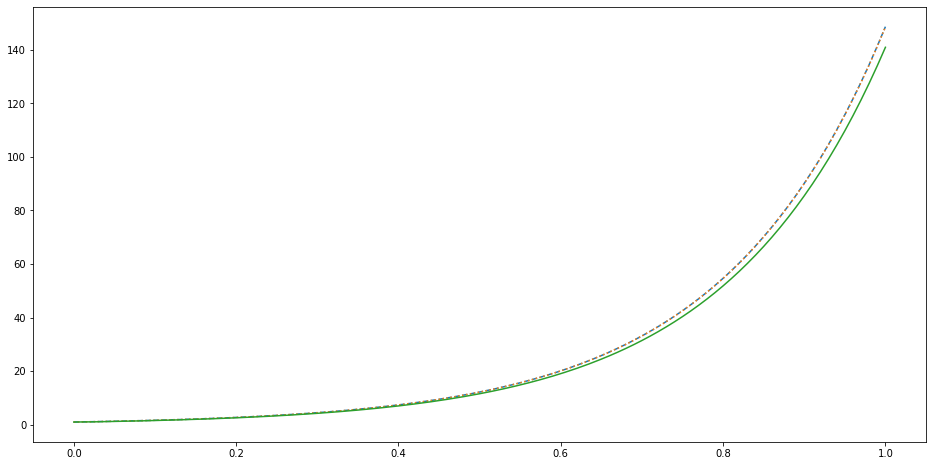

In [70]:
fig = plt.figure(figsize=(16, 8))
plt.plot(t2, x2, '--', t3, x3, ':', t4, x4)
None

## Решение задачи

### ФДН-методы

Промежуток времени, на котором решается задача - от $t_0=0$ до $T_k=3000$. Шаг $\tau$ будем брать из следующего множества: $\{ 0.5, 0.1, 0.05, 0.01, 0.001\}$. Начальные условия: $y(0)=1.7, \alpha (0) = 1$, $x(0)$ берется из множества $\{ 0.1, 0.2, \dots, 0.9\}$. Малый параметр $\epsilon$ будем брать из множества $\{ 0.01, 0.005, 0.001, 0.0005, 0.0001 \}$.

In [22]:
from itertools import product

In [26]:
def plot_with_params(x0_arr, epsilon_arr, tau_arr, method):
    x_dim, y_dim = len(x0_arr), len(epsilon_arr)
    fig, axes = plt.subplots(x_dim, y_dim)
    fig.set_size_inches(6.4 * 2.2, 4.8 * 2.2)
    fig.set_dpi(300)
    fig.suptitle(r'Фазовые траектории в зависимости от $x_0$, $\varepsilon$ и $\tau$')
    fig.tight_layout(pad=3.0)
    for i, (x0, epsilon, tau) in enumerate(product(
        x0_arr, 
        epsilon_arr, 
        tau_arr
    )):
        t, u = method(f, 0, 3000, tau, np.array([x0, 1.7, 1]), epsilon=epsilon)
        axes[i // y_dim, i % y_dim].plt(u[0], u[1])

[-0.02395481  1.8554156   0.01978418]
2 [[0.1        1.7        1.        ]
 [0.00305551 2.57111645 1.00904245]
 [0.         0.         0.        ]
 ...
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[0.1        1.7        1.         0.00305551 2.57111645 1.00904245
 0.00305551 2.57111645 1.00904245]
[ 0.5 -2.   1.5]


ValueError: shapes (9,) and (3,) not aligned: 9 (dim 0) != 3 (dim 0)

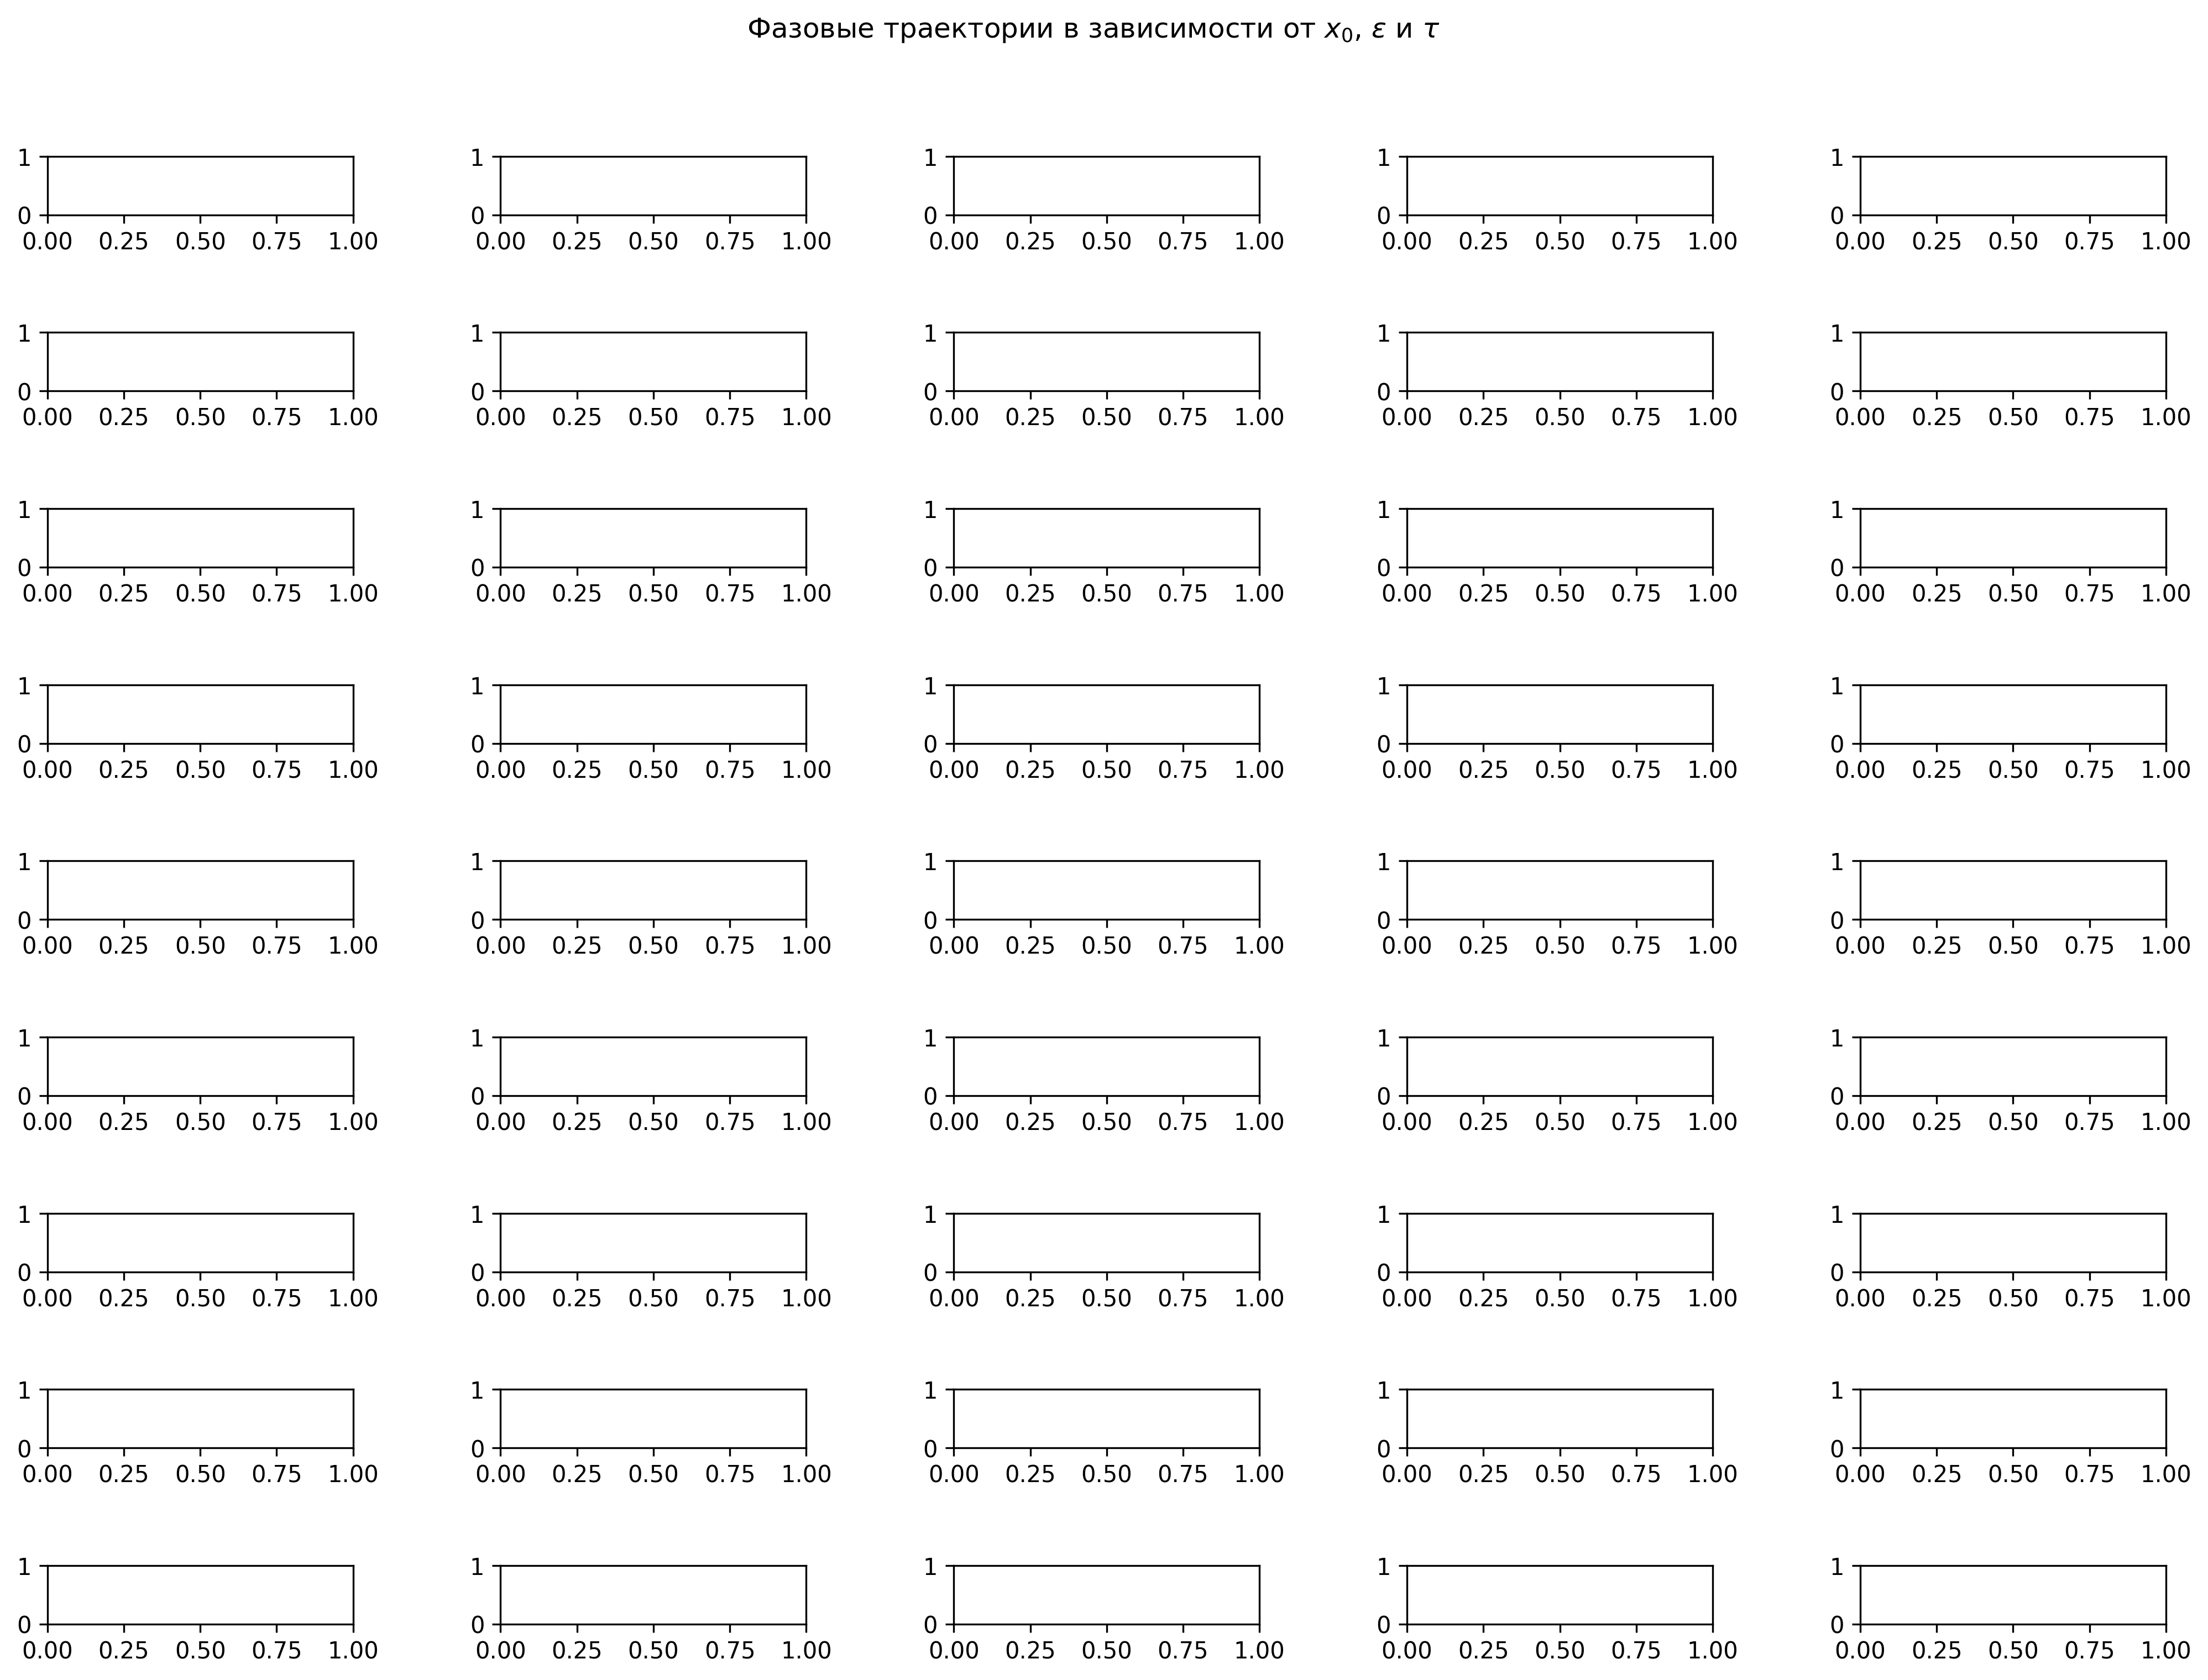

In [77]:
plot_with_params(
    np.arange(0.1, 1.0, 0.1), 
    [1e-2, 5e-3, 1e-3, 5e-4, 1e-4], 
    [0.5, 0.1, 0.05, 0.01, 0.001],
    method=BDF_order2
)